# SONG SIMILARITY PROJECT

Celeste Nicora 4727363

In questo progetto andremo ad introdurre diversi metodi per analizzare la similitudine tra due brani. Per fare ciò ricordiamo la definizione di alcuni termini musicali.

<ul> 
<li> Una nota (pitch) è la percezione umana di un'onda ad una frequenza specifica, per esempio la nota A4 corrisponde a 440 Hz. Nella notazione anglosassone A indica il chroma, o la qualità della nota, mentre 4 simboleggia l'ottava. </li>
<li>Una scala è una sequenza di note con un preciso spazio di frequenza, una scala inizia e finisce sulla "stessa" nota separata di un ottava (es. da C3 a C4)</li>
<li>La chiave è il gruppo di tonalità che costituisce la scala principale maggiore o minore che verrà utilizzata nella composizione.</li>
</ul>

Per analizzare la similitudine andremo ad ottenere 3 principali caratteristiche di due canzoni: 
1. chiave
2. envelope
3. BPM

Dopo questo andremo ad introdurre due algoritmi per confrontare chiavi ed envelope.

N.B: In questo notebook andremo ad utilizzare soltanto i primi 20 secondi dei brani(tranne che nella tempo recognition), in modo da ridurre i tempi di calcolo e visualizzare grafici più chiari.

### Librerie Usate:

In [2]:
import pydub 
import numpy as np
import ffmpeg
import ffprobe
from pydub import AudioSegment
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, hilbert
from matplotlib.pyplot import figure

# Come ottenere la chiave:

### Passo 0: Carichiamo i brani e creiamo la STFT
Per capire con che tipo di segnale abbiamo a che fare andiamo a riprodurre graficamente la Short-Time Fourier Transform.

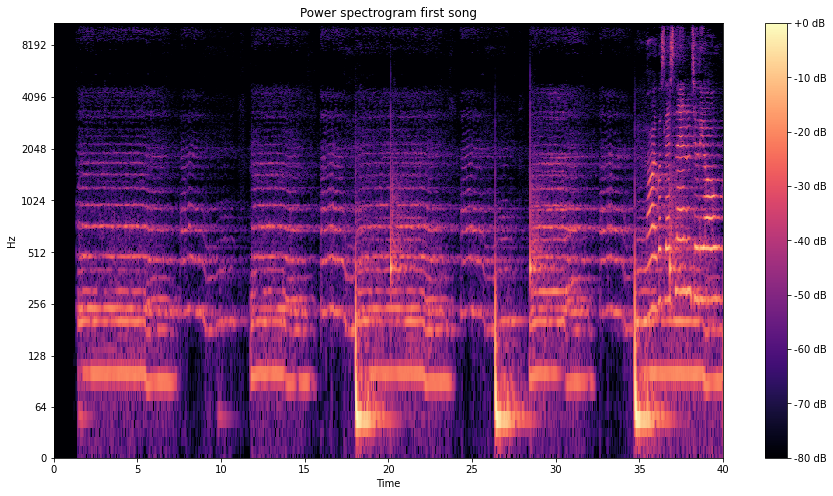

In [3]:
d=20 #scegliamo una durata di 20 secondi
x,Fs=librosa.load("RunawayWav",duration=d) #carichiamo il brano
S = np.abs(librosa.stft(x, n_fft=2048)) #calcoliamo il valore assoluto della trasformata
S_left = librosa.stft(x, center=False) #Centriamo i nostri risultati
D_short = librosa.stft(x, hop_length=1024)

#Spettogramma della prima canzone:
fig, ax = plt.subplots(figsize=(15,8))

D=librosa.amplitude_to_db(S,ref=np.max)

img = librosa.display.specshow(D,y_axis='log', x_axis='time',hop_length=1024, ax=ax)

ax.set_title('Power spectrogram first song')
fig.colorbar(img, ax=ax, format="%+2.f dB")

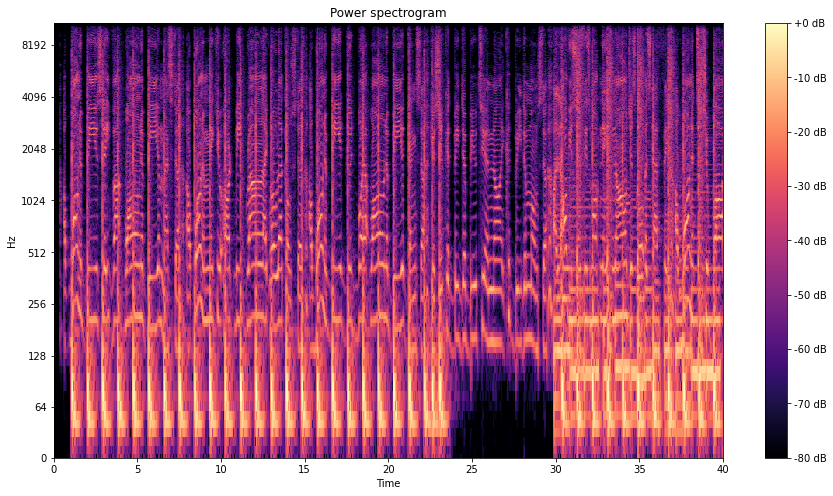

In [4]:
#Analizziamo la seconda canzone
y,Fs_y=librosa.load("RockWav",duration=d)
S = np.abs(librosa.stft(y, n_fft=2048))
S_left = librosa.stft(y, center=False)
D_short = librosa.stft(y, hop_length=1024)

#Secondo spettogramma:
fig, ax = plt.subplots(figsize=(15,8))

D=librosa.amplitude_to_db(S,ref=np.max)

img = librosa.display.specshow(D,y_axis='log', x_axis='time',hop_length=1024, ax=ax)

ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.f dB")

## Mel Spectogram

Gli studi hanno dimostrato che gli esseri umani non percepiscono le frequenze su una scala lineare. Siamo più bravi a rilevare le differenze nelle frequenze più basse rispetto alle frequenze più alte. Ad esempio, possiamo facilmente capire la differenza tra 500 e 1000 Hz, ma difficilmente saremo in grado di distinguere tra 10.000 e 10.500 Hz.

Nel 1937, Stevens, Volkmann e Newmann proposero un'unità di intonazione tale che distanze uguali di intonazione suonassero ugualmente distanti dall'ascoltatore. Questa è chiamata scala mel.
Utilizziamo anche uno spettogramma su scala Mel per vedere meglio come noi potremmo percepire il suono.

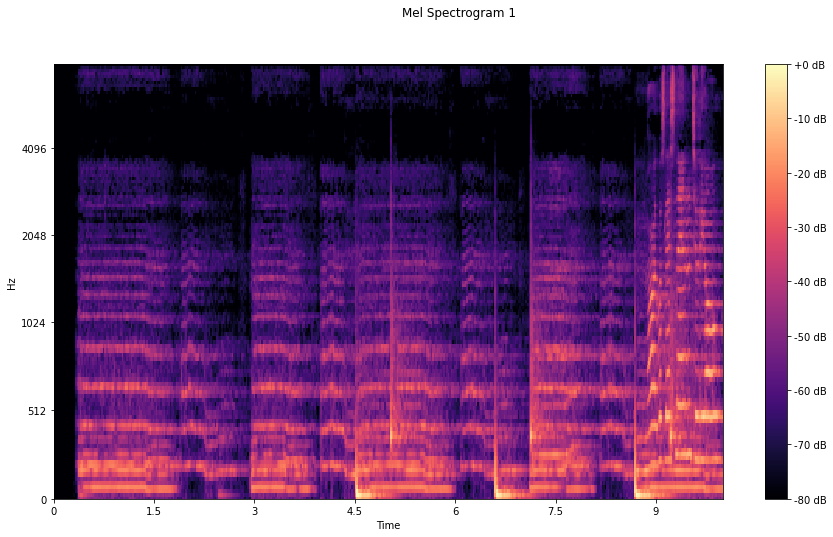

In [5]:
mel_spect = librosa.feature.melspectrogram(y=x, sr=Fs, n_fft=2048, hop_length=1024)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
fig, ax1 = plt.subplots(figsize=(15,8))

img1=librosa.display.specshow(mel_spect, y_axis='mel', fmax=8000, x_axis='time',ax=ax1);
fig.suptitle('Mel Spectrogram 1');
fig.colorbar(img1,format='%+2.0f dB');

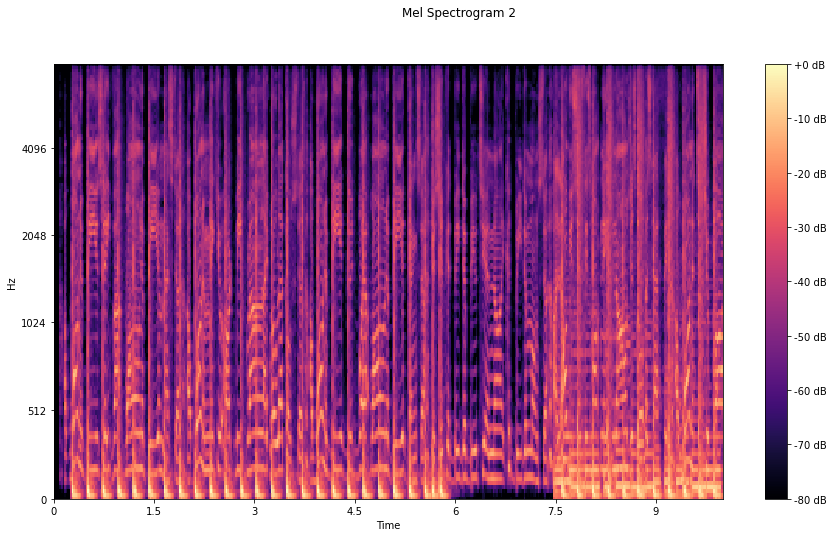

In [6]:
mel_spect2 = librosa.feature.melspectrogram(y=y, sr=Fs_y, n_fft=2048, hop_length=1024)
mel_spect2 = librosa.power_to_db(mel_spect2, ref=np.max)
fig, ax2 = plt.subplots(figsize=(15,8))
img2=librosa.display.specshow(mel_spect2, y_axis='mel', fmax=8000, x_axis='time',ax=ax2);
fig.suptitle('Mel Spectrogram 2');
fig.colorbar(img2,format='%+2.0f dB');

# Chromagram
## 1° passo: verso l'identificazione della chiave
Un cromagramma, come ci dice il nome, si occupa di raggruppare tutte le frequenze che cadono in un certo chroma e creare un grafico chroma-tempo nel quale andremo a visualizzare l'intensità di ogni chroma al variare del tempo. La libreria librosa ci fornisce una funzione predefinita per il calcolo, grazie a questo la visualizzazione risulta semplice.

[Text(0.5, 1.0, 'Chromagram Runaway')]

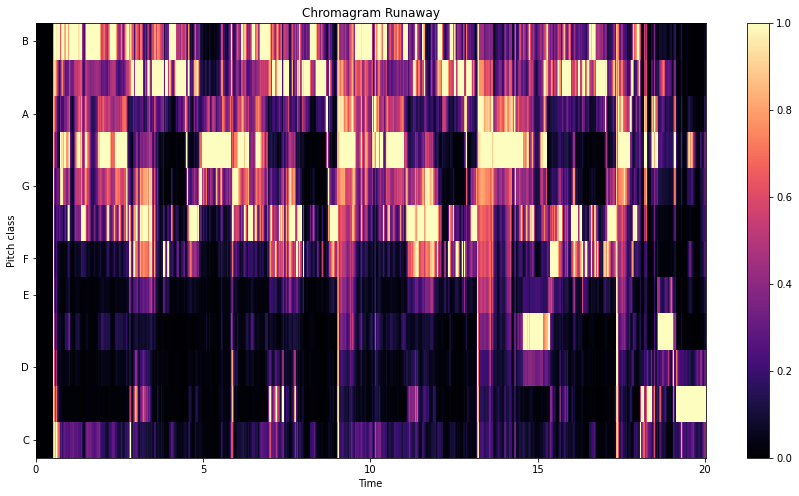

In [7]:
#Cromagramma della prima canzone
chroma = librosa.feature.chroma_stft(y=x, sr=Fs)
fig2,ax=plt.subplots(figsize=(15,8))
img = librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', ax=ax)
fig2.colorbar(img, ax=ax)
ax.set(title='Chromagram Runaway')

[Text(0.5, 1.0, 'Chromagram Rock')]

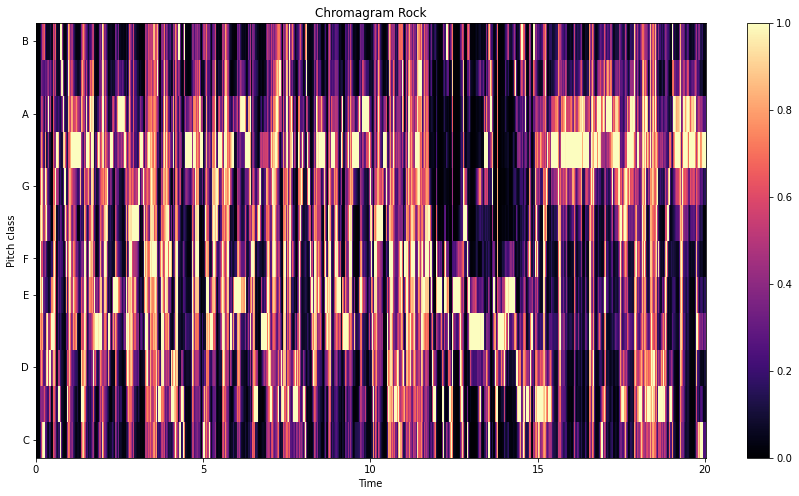

In [8]:
#Seconda canzone
chroma2 = librosa.feature.chroma_stft(y=y, sr=Fs_y)
fig2,ax2=plt.subplots(figsize=(15,8))
img = librosa.display.specshow(chroma2, y_axis='chroma', x_axis='time', ax=ax2)
fig2.colorbar(img, ax=ax2)
ax2.set(title='Chromagram Rock')

Osservazioni: possiamo notare nel primo grafico come già a vista d'occhio sia visibile quale sia il chroma prevalente, mentre dall'analisi della seconda canzone risulta confuso.

## 2° passo: Krumhansl-Schmuckler key estimation 
A questo punto abbiamo il nostro cromagramma, che useremo come pitch class distribution e che daremo in input ad un algoritmo creato appositamente per la stima della chiave. Questo algoritmo di basa su un coefficiente di correlazione dato dalla formula:
![formula.jpg](files/formula.jpg)


In [9]:
import scipy.linalg
import scipy.stats

def ks_key(X):
    '''
    
    Parameters
    ----------
    X : np.ndarray, shape=(12,)
        Pitch-class energy distribution.  Need not be normalized
        
    Returns
    -------
    major : np.ndarray, shape=(12,)
    minor : np.ndarray, shape=(12,)
    
        For each key (C:maj, ..., B:maj) and (C:min, ..., B:min),
        the correlation score for `X` against that key.
    '''
    X = scipy.stats.zscore(X)
    
    # Coefficients from Kumhansl and Schmuckler
    # as reported here: http://rnhart.net/articles/key-finding/
    major = np.asarray([6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88])
    major = scipy.stats.zscore(major)
    
    minor = np.asarray([6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17])
    minor = scipy.stats.zscore(minor)
    
    # Generate all rotations of major
    major = scipy.linalg.circulant(major)
    minor = scipy.linalg.circulant(minor)
    
    return major.T.dot(X), minor.T.dot(X)

Dopo aver definito la funzione andiamo ad applicarla ad entrambe le canzoni, e prendiamo per ogni secondo il coefficiente di correlazione più alto (0 nessuna relazione, 1 relazione lineare), ora associamo il coefficiente massimo al chroma di cui parla e cerchiamo il chroma che appare più volte. In questo modo avremo ottenuto una stima della chiave.
E' bene notare dato che analizziamo soltanto una parte di canzone il risultato non sia altrettanto accurato come nel caso in cui analizzassimo l'intero brano.

In [10]:
from collections import Counter
rows = len(chroma[0])
beat=chroma.T
rows2 = len(chroma2[0])
beat2=chroma2.T

major = [0]*12
minor = [0]*12
positionMajor = [0]*rows
positionMinor = [0]*rows

majorKey = np.asarray([6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88])
minorKey = np.asarray([6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17])
  
def most_frequent(List):
    occurence_count = Counter(List)
    return occurence_count.most_common(1)[0][0]
    

for i in range (1,rows-1):
    major,minor=ks_key(beat[i])
    positionMajor[i]=np.argmax(major)
    positionMinor[i]=np.argmax(minor)

print("Primo brano:")
print(majorKey[most_frequent(positionMajor)])
print(minorKey[most_frequent(positionMinor)])

for i in range (1,rows-1):
    major,minor=ks_key(beat2[i])
    positionMajor[i]=np.argmax(major)
    positionMinor[i]=np.argmax(minor)

print("Secondo brano:")
print(majorKey[most_frequent(positionMajor)])
print(minorKey[most_frequent(positionMinor)])

Primo brano:
2.88
3.98
Secondo brano:
2.39
3.98


Adesso associamo i valori alle corrispettive chiavi, in entrambe le scale:

![img1scala.jpg](files/img1scala.jpg)
![image1.png](files/notazione-anglosassone-1024x184.png)

## Estrazione di un envelope
### Primo metodo: Hilbert transform con un LPF
La Trasformata di Hilbert è una particolare rappresentazione che, contrariamente ad altre
trasformate (Fourier, Laplace, Z, …) non realizza un cambiamento del dominio di definizione. In
altre parole, a partire da una funzione del tempo s(t), la trasformata di Hilbert ( ) ~s t è ancora una
funzione del tempo. In questo, la trasformata di Hilbert è simile al teorema del campionamento, che
pure costituisce una rappresentazione di un segnale analogico, sotto determinate condizioni.

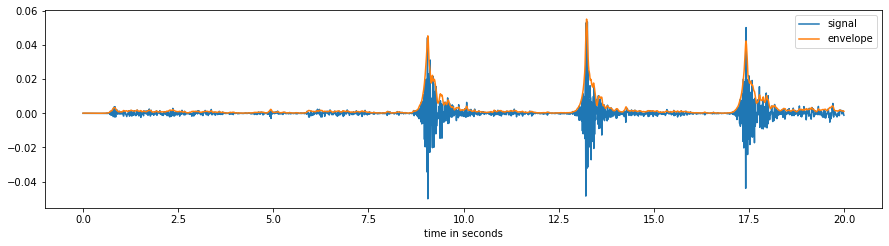

In [11]:
#definiamo un filtro passa basso
def FilteredSignal(signal, fs, cutoff):
    B, A = butter(1, cutoff / (fs / 2), btype='low')
    filtered_signal = filtfilt(B, A, signal, axis=0)
    return filtered_signal

#carichiamo nuovamente il file con un sample rate più basso per una migliore visione
x2,sr2=librosa.load("RunawayWav",sr=100,duration=d)
samples = int(sr2*d)
t = np.arange(samples) / sr2
analytic_signal=scipy.signal.hilbert(x2, N=None, axis=- 1)

amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = np.diff(instantaneous_phase) / (2.0*np.pi) * sr2

cutoff=10
filteredSignal = FilteredSignal(amplitude_envelope, sr2, cutoff)


fig = plt.figure(figsize=(15,8))
ax0 = fig.add_subplot(211)
ax0.plot(t, x2, label='signal')
ax0.plot(t, filteredSignal, label='envelope')
ax0.set_xlabel("time in seconds")
ax0.legend()

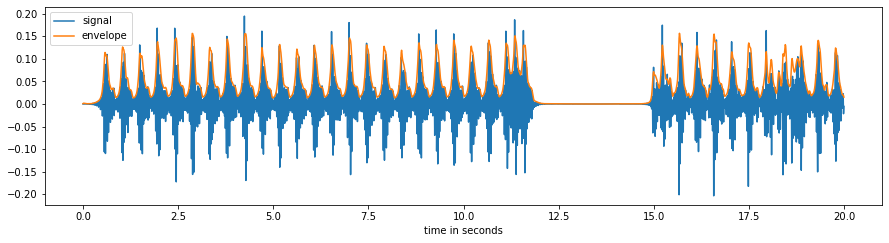

In [12]:
#facciamo lo stesso per la seconda canzone
y2,sry2=librosa.load("RockWav",sr=100,duration=d)
samples = int(sry2*d)
t = np.arange(samples) / sry2
analytic_signal=scipy.signal.hilbert(y2, N=None, axis=- 1)

amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = np.diff(instantaneous_phase) / (2.0*np.pi) * sry2

cutoff=10
filteredSignal2 = FilteredSignal(amplitude_envelope, sry2, cutoff)

fig = plt.figure(figsize=(15,8))
ax0 = fig.add_subplot(211)
ax0.plot(t, y2, label='signal')
ax0.plot(t, filteredSignal2, label='envelope')
ax0.set_xlabel("time in seconds")
ax0.legend()

### Secondo metodo: funzione alto/basso
Per dare un esempio di confronto definiamo anche una funzione che analizza sia un envelope del limite superiore sia di quello inferiore.

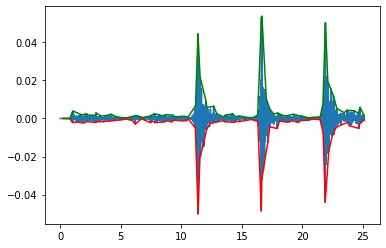

In [13]:
def hl_envelopes_idx(s, dmin=1, dmax=1, split=False):
    """
    Input :
    s: 1d-array, data signal from which to extract high and low envelopes
    dmin, dmax: int, optional, size of chunks, use this if the size of the input signal is too big
    split: bool, optional, if True, split the signal in half along its mean, might help to generate the envelope in some cases
    Output :
    lmin,lmax : high/low envelope idx of input signal s
    """

    # locals min      
    lmin = (np.diff(np.sign(np.diff(s))) > 0).nonzero()[0] + 1 
    # locals max
    lmax = (np.diff(np.sign(np.diff(s))) < 0).nonzero()[0] + 1 
    

    if split:
        # s_mid is zero if s centered around x-axis or more generally mean of signal
        s_mid = np.mean(s) 
        # pre-sorting of locals min based on relative position with respect to s_mid 
        lmin = lmin[s[lmin]<s_mid]
        # pre-sorting of local max based on relative position with respect to s_mid 
        lmax = lmax[s[lmax]>s_mid]


    # global max of dmax-chunks of locals max 
    lmin = lmin[[i+np.argmin(s[lmin[i:i+dmin]]) for i in range(0,len(lmin),dmin)]]
    # global min of dmin-chunks of locals min 
    lmax = lmax[[i+np.argmax(s[lmax[i:i+dmax]]) for i in range(0,len(lmax),dmax)]]
    
    return lmin,lmax

t = np.linspace(0,8*np.pi,sr2*d)
high_idx, low_idx = hl_envelopes_idx(x2,dmin=10,dmax=10)

# plot 1
plt.plot(t,x2,label='signal')
plt.plot(t[high_idx], x2[high_idx], 'r', label='low')
plt.plot(t[low_idx], x2[low_idx], 'g', label='high')

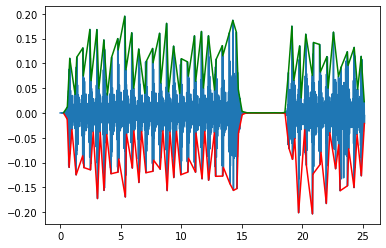

In [14]:
t = np.linspace(0,8*np.pi,sry2*d)
high_idx, low_idx = hl_envelopes_idx(y2,dmin=10,dmax=10)

# plot 2
plt.plot(t,y2,label='signal')
plt.plot(t[high_idx], y2[high_idx], 'r', label='low')
plt.plot(t[low_idx], y2[low_idx], 'g', label='high')

Vediamo come nel caso di alto/basso le variazioni molto ampie non siano sopportate particolarmente bene, quindi per il nostro algoritmo successivo andremo ad utilizzare Hilbert Tranform.

## Tempo recognition
Adesso passiamo al nostro ultimo parametro, il tempo, ovvero BPM (Beats Per Minute), in questo caso andremo ad utilizzare una funzione predefinita di librosa e calcoleremo sia il tempo uniformato che non.

In [15]:
import scipy.stats

xAll, srAll_x = librosa.load("RunawayWav")
prior = scipy.stats.uniform(30, 300)  # uniform over 30-300 BPM
onset_env = librosa.onset.onset_strength(xAll, sr=srAll_x)
utempo = librosa.beat.tempo(onset_envelope=onset_env, sr=srAll_x, prior=prior)
print(utempo)
tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=srAll_x)
print(tempo)


[57.421875]
[112.34714674]


In [16]:
yAll, srAll_y = librosa.load("RockWav")
prior = scipy.stats.uniform(30, 300)
onset_env2 = librosa.onset.onset_strength(yAll, sr=srAll_y)
utempo2 = librosa.beat.tempo(onset_envelope=onset_env2, sr=srAll_y, prior=prior)
print(utempo2)
tempo2 = librosa.beat.tempo(onset_envelope=onset_env2, sr=srAll_y)
print(tempo2)

[129.19921875]
[129.19921875]


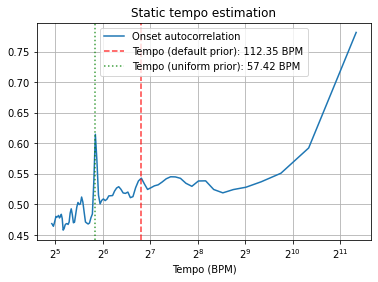

In [17]:
tempo = tempo.item()
utempo = utempo.item()
# Compute 2-second windowed autocorrelation
hop_length = 512
ac = librosa.autocorrelate(onset_env, 2 * Fs // hop_length)
freqs = librosa.tempo_frequencies(len(ac), sr=Fs,
                                  hop_length=hop_length)
# Plot on a BPM axis.  We skip the first (0-lag) bin.
fig3, ax3 = plt.subplots()
ax3.semilogx(freqs[1:], librosa.util.normalize(ac)[1:],
             label='Onset autocorrelation', base=2)
ax3.axvline(tempo, 0, 1, alpha=0.75, linestyle='--', color='r',
            label='Tempo (default prior): {:.2f} BPM'.format(tempo))
ax3.axvline(utempo, 0, 1, alpha=0.75, linestyle=':', color='g',
            label='Tempo (uniform prior): {:.2f} BPM'.format(utempo))
ax3.set(xlabel='Tempo (BPM)', title='Static tempo estimation')
ax3.grid(True)
ax3.legend()

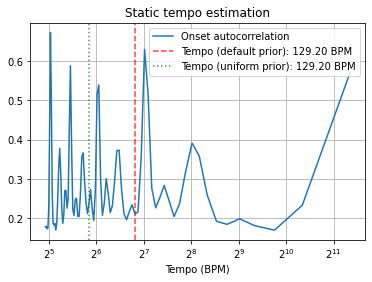

In [18]:
tempo2 = tempo2.item()
utempo2 = utempo2.item()
# Compute 2-second windowed autocorrelation
hop_length = 512
ac = librosa.autocorrelate(onset_env2, 2 * srAll_y // hop_length)
freqs = librosa.tempo_frequencies(len(ac), sr=srAll_y,
                                  hop_length=hop_length)
# Plot on a BPM axis.  We skip the first (0-lag) bin.
fig3, ax3 = plt.subplots()
ax3.semilogx(freqs[1:], librosa.util.normalize(ac)[1:],
             label='Onset autocorrelation', base=2)
ax3.axvline(tempo, 0, 1, alpha=0.75, linestyle='--', color='r',
            label='Tempo (default prior): {:.2f} BPM'.format(tempo2))
ax3.axvline(utempo, 0, 1, alpha=0.75, linestyle=':', color='g',
            label='Tempo (uniform prior): {:.2f} BPM'.format(utempo2))
ax3.set(xlabel='Tempo (BPM)', title='Static tempo estimation')
ax3.grid(True)
ax3.legend()

# Calcolo della differenza
Ora che abbiamo ottenuto tutti i valori dei nostri brani è il momento di introdurre i criteri di differenza. Per le chiavi useremo il KEY SIMILARITY ALGORITHM.


## Key similarity:

In [19]:
COF = np.asarray(['C','Em','G','Bm','D','F#m',
'A','C#m','E','G#m','B','D#m','F#',
'A#m','C#','Fm','G#','Cm','D#','Gm',
'A#','Dm','F','Am'])
def findString(l,val):
    s = val
    length = len(COF)
    for i in range(0,length-1):
        if s == l[i]:
            return i
    
def KSA(key1,key2):
    val1=findString(COF,key1)
    val2=findString(COF,key2)
    D = abs(val1-val2)
    if D > len(COF)/2:
        D=len(COF)-val2+val1
    else:
        D=len(COF)-val1+val2

    result = abs((len(COF)-D)/len(COF))*100
    return result

In [20]:
score1=KSA('B','G#')
print(score1)

25.0


Possiamo notare che data la distanza tra le due chiavi l'algoritmo ci da una differenza del 25.0%

## All Common Subsequence algorithm

Adesso passiamo all'analisi più dettagliata della somiglianza tra le due envelope, nel quale andremo ad utilizzare una variante del LCS Algorithm, il quale tiene conto di tutte le sottosequenze simili, in modo che se una canzone abbia più momenti simili lo score sia più alto. Per fare ciò utilizziamo il primo metodo che ci ha restituito l'envelope dato che come abbiamo visto è quello che sopporta meglio le grandi differenze.

In [21]:
def ACS(a,b,thresh,tolerance):
    len_a = len(a)
    len_b = len(b)
    rows, cols = (len_a, len_b)
    c = [[0]*cols]*rows
    for i in range(1,len_a):
        for j in range(1,len_b):
            c[i][j]=abs(a[i]-b[j])
    sumtot=0
    for i in range(1,len_a):
        for j in range(1,len_b):  
            length = 0
            m=i
            n=j
            while m>0 and n>0 and c[m][n]>=0 and abs(c[m][n]-c[i][j])<tolerance:
                length+=1
                if length >=thresh:
                    c[m][n]=-1
                m=m-1
                n=n-1
            if length >= thresh:
                sumtot=sumtot+length
    avg=(len_a+len_b)/2
    score=sumtot/avg
    n=n-1
    return score

In [22]:
score=ACS(filteredSignal,filteredSignal2,100,0.04)
print(score)

11.4


Osservazioni: Vediamo che la differenza è solo di 11.4% nonostante la key similarity ci abbia dato un valore molto più alto, per confrontare questo valore adesso usiamo un brano di musica classica ed uno di elettronica

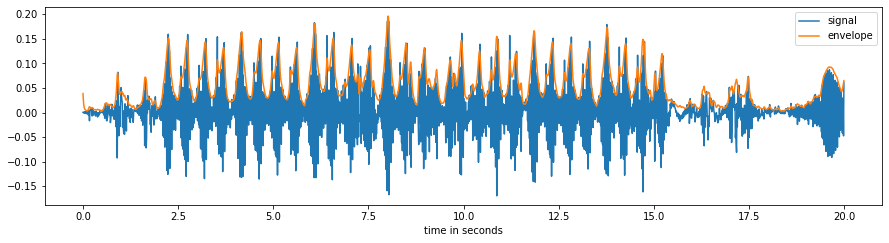

In [23]:
#carichiamo un brano di elettronica
es3,srEs3=librosa.load("TechnoWav",sr=100,duration=d)

samples = int(srEs3*d)
t = np.arange(samples) / srEs3
analytic_signal=scipy.signal.hilbert(es3, N=None, axis=- 1)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = np.diff(instantaneous_phase) / (2.0*np.pi) * srEs3
filteredSignal3 = FilteredSignal(amplitude_envelope, srEs3, cutoff)

#Visualizziamo il grafico
fig = plt.figure(figsize=(15,8))
ax0 = fig.add_subplot(211)
ax0.plot(t, es3, label='signal')
ax0.plot(t, filteredSignal3, label='envelope')
ax0.set_xlabel("time in seconds")
ax0.legend()

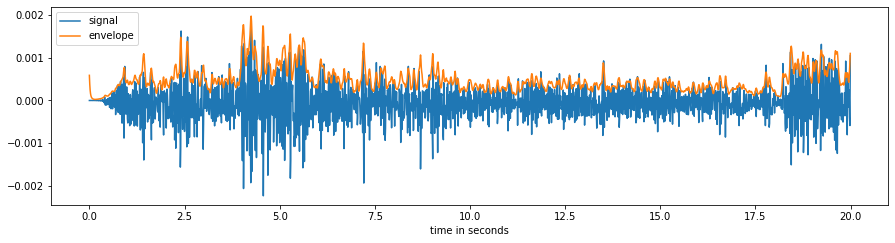

In [24]:
#carichiamo un brano di classica
es4,srEs4=librosa.load("PaganiniWav",sr=100,duration=d)

samples = int(srEs4*d)
t = np.arange(samples) / srEs4
analytic_signal=scipy.signal.hilbert(es4, N=None, axis=- 1)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = np.diff(instantaneous_phase) / (2.0*np.pi) * srEs4
filteredSignal4 = FilteredSignal(amplitude_envelope, srEs4, cutoff)

#Visualizziamo il grafico
fig = plt.figure(figsize=(15,8))
ax0 = fig.add_subplot(211)
ax0.plot(t, es4, label='signal')
ax0.plot(t, filteredSignal4, label='envelope')
ax0.set_xlabel("time in seconds")
ax0.legend()

In [117]:
print("differenza brano musica elettronica e classica:")
score=ACS(filteredSignal3,filteredSignal4,100,0.04)
print(score)

differenza brano musica elettronica e classica:
95.0


Come possiamo notare la differenza è estremamente elevata, anche se il grafico ci appare più simile, questo è dato dal fatto che le frequenze del brano di musica classica siano molto più ridotte rispetto al brano di elettronica, quindi la loro differenza super nettamente il valore di tolerance. 

In [118]:
print("differenza brano musica rock ed elettronica:")
score=ACS(filteredSignal2,filteredSignal3,100,0.04)
print(score)

differenza brano musica rock ed elettronica:
12.1


## Euclidean distance method
Come ultimo esempio andiamo ad applicare un metodo molto semplice di distanza euclidiana per vedere se i risultati combaciano con ACS.

In [25]:
# initializing points in
# numpy arrays
point1 = filteredSignal
point2 = filteredSignal2
point3 = filteredSignal3
point4 = filteredSignal4
 
# calculating Euclidean distance
# using linalg.norm()
dist = np.linalg.norm(point1 - point2)
 
# printing Euclidean distance
print("differenza euclidiana brano musica rock ed pop:")
print(dist)

 
# calculating Euclidean distance
# using linalg.norm()
dist = np.linalg.norm(point3 - point4)
 
# printing Euclidean distance
print("differenza euclidiana brano musica elettronica ed classica:")
print(dist)

 
# calculating Euclidean distance
# using linalg.norm()
dist = np.linalg.norm(point2 - point3)
 
# printing Euclidean distance
print("differenza euclidiana brano musica rock ed elettronica:")
print(dist)

differenza euclidiana brano musica rock ed pop:
2.7385815059644063
differenza euclidiana brano musica elettronica ed classica:
3.0341759160016344
differenza euclidiana brano musica rock ed elettronica:
2.6300913029875916


# Conclusioni:
Possiamo notare come lo studio di envelope sia estremamente variabile in base ai valori che si scelgono come soglia e come tolleranza, inoltre è anche molto influenzato dal sampling rate. D'altro canto la tempo recognition e la key detection sono molto meno suscettibili a variazioni di piccola portata.

Le caratteristiche di un brano da studiare sono molteplici e strettamente correlate, ancora oggi gli algoritmi per suggerire ad utenti canzoni "simili" in via di sviluppo sono in continuo miglioramento e molto spesso non sono resi disponibili dato il loro valore commerciale. 
## Altre tecniche
Spotify per consigliare brani ad esempio si appoggia ad una serie di valori quali energy, speechiness, danceability ecc. 
Un altro approccio molto interessante sotto il quale si potrebbero confrontare i brani è il chord recognition, cioè scoprire tutti gli accordi di un brani. Questo sviluppo si appoggia su Neural Network e modelli come Hidden Markov Model.